In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.animation as animation
import time
import struct
import tensorflow as tf
import random as rd

from array import array
# import keras._tf_keras.keras as keras 
# from keras._tf_keras.keras
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

# my project
from module.conf import PROJECT_DIR

# matplotlib.use("QTAgg")
%matplotlib inline

1. Load data:
- Train data: 60k 28x28 images
- Test data: 

In [2]:
mnist_path = "/data/sample/mnist"
training_images_filepath = "".join([PROJECT_DIR, mnist_path, "/train-images.idx3-ubyte"])
training_labels_filepath = "".join([PROJECT_DIR, mnist_path, "/train-labels.idx1-ubyte"])
test_images_filepath = "".join([PROJECT_DIR, mnist_path, "/t10k-images.idx3-ubyte"])
test_labels_filepath = "".join([PROJECT_DIR, mnist_path, "/t10k-labels.idx1-ubyte"])

def read_images_labels(images_filepath, labels_filepath) -> tuple:
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        # labels = array("B", file.read())
        labels = array("B", file.read())

    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())       
     
    images = []
    # for i in range(size):
    #     images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        # images[i][:] = img
        images.append(img)
    
    return images, labels

def load_data() -> tuple:
    x_train, y_train = read_images_labels(training_images_filepath, training_labels_filepath)
    x_test, y_test = read_images_labels(test_images_filepath, test_labels_filepath)
    return (x_train, y_train),(x_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data()

In [3]:
# print(f"{type(X_train[0])}")
# mnist = tf.keras.datasets.mnist

# (x_train, y_train), (x_test, y_test) = mnist.load_data()


In [4]:
X_train = np.asarray(X_train)/255
y_train = np.asarray(y_train)
X_test  = np.asarray(X_test)/255
y_test  = np.asarray(y_test)

In [90]:
model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Flatten(input_shape=(28, 28,)),
    tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(units=128, activation=tf.keras.activations.hard_sigmoid),
    # tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)
])

In [91]:
# predictions = model(X_train[0]).numpy()
# predictions
# tf.nn.softmax(predictions).numpy()

In [98]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# loss_fn = tf.keras.losses.CategoricalHinge()
# loss_fn = tf.keras.losses.MeanSquaredLogarithmicError()
# model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.FalseNegatives()])
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=loss_fn,
              metrics=["accuracy"])

In [99]:
# X_train, X_test = np.asarray(X_train) / 255.0, np.asarray(X_test) / 255.0
# print(X_test)
model.fit(x=X_train, y=y_train, epochs=50, batch_size=600, workers=8, use_multiprocessing=False)

Epoch 1/2
100/100 [==============================] - 0s 2ms/step - loss: 0.3148 - accuracy: 0.9117
Epoch 2/2
100/100 [==============================] - 0s 2ms/step - loss: 0.2599 - accuracy: 0.9246


In [100]:
model.evaluate(X_test,  y_test, verbose=2)
c = 0
cp = 0
for i in range(100):
    test_indx = rd.randint(0, len(y_test)-1)
    x_test_ = np.asarray([X_test[test_indx]])

    # test_indx = rd.randint(0, len(y_train)-1)
    # x_test_ = np.asarray([X_train[test_indx]])

    result = model.predict(x=x_test_, verbose=0)
    # result = tf.nn.softmax(result).numpy()
    y_test_ = y_test
    # if result.max() >= 0.5:
    if result.argmax() != y_test_[test_indx]:
        c+=1
        print(f"- [{i}]:img[{test_indx}]:{result}\npred:{result.max()}\npredict:{result.argmax()} solve:{y_test_[test_indx]}")
    else:
        print(f"+ [{i}]:img[{test_indx}]:{result}\npred:{result.max()}\npredict:{result.argmax()} solve:{y_test_[test_indx]}")
    # else:
    #     print(f"= [{i}]:img[{test_indx}]:{result}\npred:{result.max()}\npredict:{result.argmax()} solve:{y_test_[test_indx]}")
    #     cp+=1
print(f"error: {c} can not pred:{cp}")

313/313 - 0s - loss: 0.2401 - accuracy: 0.9285 - 179ms/epoch - 572us/step
+ [0]:img[8382]:[[3.0025402e-01 4.3754975e-05 2.3189310e-03 4.7889588e-04 3.3107885e-05
  1.2001271e-03 1.4696767e-03 1.4345216e-03 3.3813845e-05 8.9077250e-05]]
pred:0.3002540171146393
predict:0 solve:0
+ [1]:img[7504]:[[5.7549438e-05 1.3324975e-04 2.3809413e-03 2.9101875e-03 6.5558314e-05
  3.8510501e-05 1.1774569e-05 2.4761394e-01 5.7309860e-04 4.6628411e-03]]
pred:0.24761393666267395
predict:7 solve:7
+ [2]:img[6639]:[[2.9507265e-04 4.5415451e-04 1.3061012e-03 5.1259307e-05 5.3037540e-04
  1.7113507e-03 1.3522030e+00 6.5729771e-05 5.6573423e-04 1.2946676e-04]]
pred:1.3522030115127563
predict:6 solve:6
+ [3]:img[8403]:[[3.2012971e-04 2.5349162e-05 1.1708135e-05 2.7151275e-04 1.2051307e-04
  6.3309108e-04 7.0142701e-06 2.7593622e-01 2.2334077e-04 6.9262590e-03]]
pred:0.27593621611595154
predict:7 solve:7
+ [4]:img[2401]:[[2.7089785e-05 6.6178036e-05 5.0740736e-04 1.2255092e-04 8.1150365e-01
  9.1275410e-04 2.51

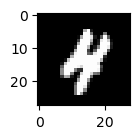

In [101]:
def show_image(img_data: np.ndarray) -> tuple:
    fig, axes = plt.subplots(figsize=(1.60, 1.20))
    axes.imshow(X=img_data, cmap="gray")
    return fig, axes

# print(y_test[5854])
show_image(X_test[7338])
plt.show()

In [97]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

Num GPUs Available:  0
